In [1]:
import pathlib

import anndata
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# from wmb import mc, brain
import pynndescent
import seaborn as sns
from ALLCools.integration import calculate_overlap_score, confusion_matrix_clustering
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from sklearn.preprocessing import OneHotEncoder, normalize
import joblib

In [2]:
var = "L4Region"
group_name = 'Slice9-10_NN'

## Load

In [4]:
adata_merge = anndata.read_h5ad("final_with_coords.h5ad")

In [5]:
data = (
    adata_merge.obs[["leiden", f"{var}"]]
    .astype(str)
    .value_counts()
    .unstack(fill_value=0)
)
mc_only_cluster = data.index[data["nan"] == 0]
data = data.drop(["nan"], axis=1)
merfish_only_cluster = data.index[data.sum(axis=1) == 0]
data = data.drop(merfish_only_cluster, axis=0)
datac = data / data.sum(axis=0)
datar = data / data.sum(axis=1)[:, None]
confusion_matrix = datar.where(datar > datac, datac)
print(mc_only_cluster.tolist(), merfish_only_cluster.tolist())

[] []


In [6]:
# confusion matrix contains mc only clusters, but not merfish only clusters
if data.values.max() > 0.1:
    (
        query_group,
        ref_group,
        confusion_matrix,
        g,
        modularity_score1,
    ) = confusion_matrix_clustering(
        confusion_matrix=confusion_matrix.T,
        min_value=0.1,
        max_value=0.9,
        partition_type=None,
        resolution=1.0,
        seed=0,
    )
else:
    ref_group = pd.Series(-1, index=data.index)
    query_group = pd.Series(-1, index=data.columns)
    confusion_matrix = confusion_matrix.T
    modularity_score1 = 0

In [7]:
print(modularity_score1, ref_group.unique().shape, query_group.unique().shape)

0.9157125690840409 (25,) (25,)


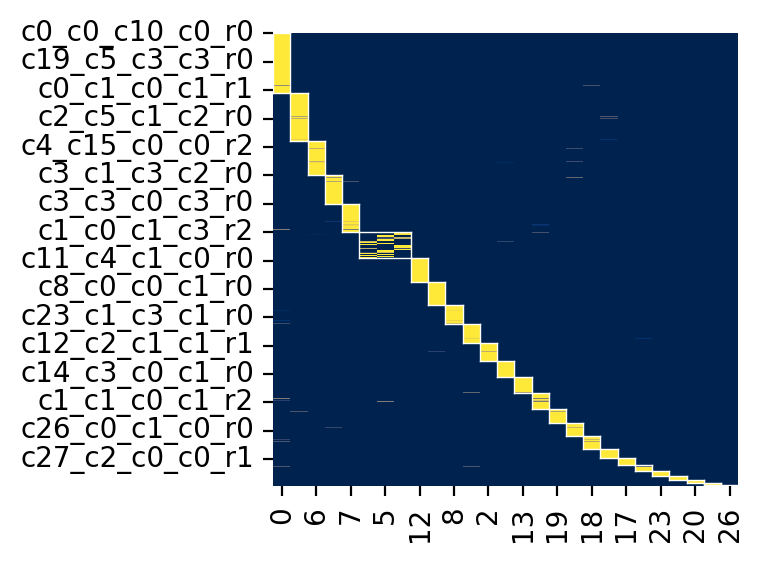

In [8]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
sns.heatmap(confusion_matrix, ax=ax, vmin=0.1, vmax=0.9, cmap="cividis", cbar=None)
cumsum_c, cumsum_r = 0, 0
for xx in ref_group.sort_values().unique():
    rlen, clen = (query_group == xx).sum(), (ref_group == xx).sum()
    ax.plot([cumsum_c, cumsum_c + clen], [cumsum_r, cumsum_r], c="w", linewidth=0.5)
    ax.plot(
        [cumsum_c, cumsum_c + clen],
        [cumsum_r + rlen, cumsum_r + rlen],
        c="w",
        linewidth=0.5,
    )
    ax.plot([cumsum_c, cumsum_c], [cumsum_r, cumsum_r + rlen], c="w", linewidth=0.5)
    ax.plot(
        [cumsum_c + clen, cumsum_c + clen],
        [cumsum_r, cumsum_r + rlen],
        c="w",
        linewidth=0.5,
    )
    cumsum_c += clen
    cumsum_r += rlen

## mc as query

In [9]:
integration_group_cluster = {}
integration_group_cell = {}

for group, leiden_inteGroup in ref_group.groupby(ref_group):
    ref_cluster = leiden_inteGroup.index
    qry_cluster = (datac.loc[ref_cluster].sum(axis=0) > 0.3) | (
        datar.loc[ref_cluster].max(axis=0) > 0.3
    )
    qry_cluster = qry_cluster.index[qry_cluster].astype(str)

    ref_cell = adata_merge.obs.index[
        (adata_merge.obs["Modality"] == "merfish")
        & (adata_merge.obs["leiden"].isin(ref_cluster))
    ]
    qry_cell = adata_merge.obs.index[
        (adata_merge.obs["Modality"] == "mC")
        & (adata_merge.obs[f"{var}"].isin(qry_cluster))
    ]

    if (len(qry_cell) > 0) and (len(ref_cell) > 0):
        integration_group_cluster[f"IG{group}"] = {
            "ref": ref_cluster.tolist(),
            "qry": qry_cluster.tolist(),
        }
        integration_group_cell[f"IG{group}"] = {
            "ref": ref_cell.tolist(),
            "qry": qry_cell.tolist(),
        }
    else:
        print(group, ref_cluster, qry_cluster)
print(len(integration_group_cluster), len(integration_group_cell))

25 25


In [10]:
all_ref_clusters, all_qry_clusters = [], []
for group, group_dict in integration_group_cluster.items():
    if group != -1:
        all_ref_clusters += group_dict["ref"]
        all_qry_clusters += group_dict["qry"]

all_ref_clusters = set(all_ref_clusters)
all_qry_clusters = set(all_qry_clusters)
print(len(all_ref_clusters), len(all_qry_clusters))

27 1260


In [11]:
mc_cell = (adata_merge.obs["Modality"] == "mC") & (
    adata_merge.obs[f"{var}"].isin(all_qry_clusters)
)
merfish_cell = (adata_merge.obs["Modality"] == "merfish") & (
    adata_merge.obs["leiden"].isin(all_ref_clusters)
)
print(mc_cell.sum(), merfish_cell.sum())
cluster = pd.DataFrame(
    -1,
    index=adata_merge.obs.index[adata_merge.obs["Modality"] == "merfish"],
    columns=[f"{var}", f"{var}_score",'CellType','CellType_score'],
)

30000 30194


In [12]:
chunk_size = 50000
if (mc_cell.sum() > 0) and (merfish_cell.sum() > 0):
    # assign merfish cell to mc clusters
    sd = 1

    index = pynndescent.NNDescent(
        adata_merge.obsm["X_pca_integrate"][mc_cell],
        metric="euclidean",
        n_neighbors=min(50, mc_cell.sum()),
        random_state=0,
        n_jobs=-1)  # get mc index first
    G, D = index.query(adata_merge.obsm["X_pca_integrate"][merfish_cell], k=min(25, mc_cell.sum()))
    
    # np.savez(
    #     "MERFISH_mCxNN.npz",
    #     G=G,
    #     D=D,
    #     mc_cell=adata_merge.obs.index[mc_cell],
    #     merfish_cell=adata_merge.obs.index[merfish_cell])
        
    cellfilter = D[:, -1] == 0
    D = 1 - D / D[:, -1][:, None]
    D[cellfilter] = 1
    D = 1 - np.exp(-D * (sd**2) / 4)
    D = D / (np.sum(D, axis=1) + 1e-6)[:, None]

    enc = OneHotEncoder()
    for _var in ['L4Region', 'CellType']:
        labelref = enc.fit_transform(adata_merge.obs.loc[mc_cell, [f"{_var}"]].values.astype(str))
        for chunk_start in range(0, merfish_cell.sum(), chunk_size):
            result = (D[chunk_start : (chunk_start + chunk_size), :, None] * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()].toarray().reshape((-1, min(25, mc_cell.sum()), enc.categories_[0].shape[0]))).sum(axis=1)
            result = pd.DataFrame(result, columns=enc.categories_[0], index=adata_merge.obs.index[merfish_cell][chunk_start : (chunk_start + chunk_size)])

            cluster.loc[result.index, f"{_var}"] = result.idxmax(axis=1).values
            cluster.loc[result.index, f"{_var}_score"] = result.max(axis=1).values

    # cluster.to_hdf('MERFISH_mc_cluster.hdf', key='data')


In [15]:
merfish_meta = pd.read_csv('/home/qzeng_salk_edu/project/cemba/230223_spatial/integration/_prepare/merfish_meta.tenx.csv',index_col = 0)

In [16]:
cluster['tenx_cell_type'] = merfish_meta['cell_type']
(cluster['CellType'] == cluster['tenx_cell_type']).sum() / cluster.shape[0]

0.7109690667019938

## mc as ref

In [9]:
integration_group_cluster = {}
integration_group_cell = {}

for group, leiden_inteGroup in ref_group.groupby(ref_group):
    qry_cluster = leiden_inteGroup.index
    
    ref_cluster = (datac.loc[qry_cluster].sum(axis=0) > 0.3) | (datar.loc[qry_cluster].max(axis=0) > 0.3)
    
    ref_cluster = ref_cluster.index[ref_cluster].astype(str)
    
    ref_cell = adata_merge.obs.index[
        (adata_merge.obs["Modality"] == "mC") & 
        (adata_merge.obs[f"{var}"].isin(ref_cluster))]
    
    qry_cell = adata_merge.obs.index[
        (adata_merge.obs["Modality"] == "merfish")
        & (adata_merge.obs["leiden"].isin(qry_cluster))]
    
    if (len(qry_cell) > 0) and (len(ref_cell) > 0):
        integration_group_cluster[f"IG{group}"] = {
            "ref": ref_cluster.tolist(),
            "qry": qry_cluster.tolist(),
        }
        integration_group_cell[f"IG{group}"] = {
            "ref": ref_cell.tolist(),
            "qry": qry_cell.tolist(),
        }
    else:
        print(group, ref_cluster, qry_cluster)
print(len(integration_group_cluster), len(integration_group_cell))

25 25


In [10]:
all_ref_clusters, all_qry_clusters = [], []
for group, group_dict in integration_group_cluster.items():
    if group != -1:
        all_ref_clusters += group_dict["ref"]
        all_qry_clusters += group_dict["qry"]

all_ref_clusters = set(all_ref_clusters)
all_qry_clusters = set(all_qry_clusters)
print(len(all_ref_clusters), len(all_qry_clusters))

1260 27


In [11]:
mc_cell = (adata_merge.obs["Modality"] == "mC") & (
    adata_merge.obs[f"{var}"].isin(all_ref_clusters))
merfish_cell = (adata_merge.obs["Modality"] == "merfish") & (
    adata_merge.obs["leiden"].isin(all_qry_clusters))
    
print(mc_cell.sum(), merfish_cell.sum())

cluster = pd.DataFrame(
    -1,
    index=adata_merge.obs.index[adata_merge.obs["Modality"] == "merfish"],
    columns=[f"{var}", f"{var}_score",'CellType','CellType_score'],
)

30000 30194


In [12]:
chunk_size = 50000
if (mc_cell.sum() > 0) and (merfish_cell.sum() > 0):
    for knn in [25]:
        # assign mc cell to merfish clusters
        sd = 1
        index = pynndescent.NNDescent(
            adata_merge.obsm["X_pca_integrate"][merfish_cell],
            metric="euclidean",
            n_neighbors=min(50, merfish_cell.sum()),
            random_state=0,
            n_jobs=-1)  # get mc index first
        G, D = index.query(adata_merge.obsm["X_pca_integrate"][mc_cell], k=min(knn, merfish_cell.sum()))

        np.savez(
            f"mC_MERFISHxNN.npz",
            G=G,
            D=D,
            merfish_cell=adata_merge.obs.index[merfish_cell],
            mc_cell=adata_merge.obs.index[mc_cell])
        
        print(G.shape)

(30000, 10)
(30000, 25)
(30000, 50)
